In this practical we will train SARSA Q-learning and Monte-Carlo agents on the cliff walking environment: https://www.gymlibrary.dev/environments/toy_text/cliff_walking/ . And have a look at the different behaviours of on and off policy learning

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

import sys

!ls /content/gdrive/MyDrive/Colab\ Notebooks

sys.path.append('/content/gdrive/MyDrive/Colab Notebooks/L2D-reinforcement_learning/lib')

Mounted at /content/gdrive
 agents_nt.py					  L2D-reinforcement_learning
 BIOS0040-CPS-10-frozen-lake.ipynb		  __pycache__
 BIOS0040-CPS-10-frozen-lake_solution.ipynb	  utils_nt.py
 BIOS0040-Week-10-practical-cliff-walking.ipynb   W10_lecture1.pptx
'Copy of GymRendering.ipynb'


In [ ]:
!pip install gymnasium[toy_text]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.7 MB 5.2 MB/s 


In [ ]:

!apt-get install x11-utils > /dev/null 2>&1 
!pip install pyglet > /dev/null 2>&1 
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install pyvirtualdisplay > /dev/null 2>&1

In [21]:


import os

from agents_nt import MC_agent, TD_agent
from utils_nt import plot_value, plot_returns, plot_explore
import numpy as np
import matplotlib.pyplot as plt

import gymnasium as gym
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

import time
    

## Training loop
Try and understand roughly how this code works:
* Where is the agents policy queried to get the next action?
* Where is the action applied to the environment?
* Where is the state, action, reward, next_state, next_action constructed?
* Which block of code runs an entire episode?
* Find where the different agents are updated, why is monte-carlo agent updated in a different place in the code?

In [22]:
def train_agent(agent, env,  n_episodes = 10001, explore_rate = 0.05, monte_carlo = False, display=False, simple_text = False):

    returns = []

    if display:
      display = Display(visible=0, size=(400, 300))
      display.start()
    
    for episode in range(0,n_episodes): # for each episode

        e_return = 0 # sum the reward we get this episode
        e_transitions = [] # memory of all tranisitions seen in this episode
        done = False # has the episode finished?
        
        state, prob = env.reset() # reset env to initial state

 
        action = agent.policy(state, explore_rate) # initialise the agent

        if display: # display the current agent-evironment state
            #env.render()
            plt.imshow(env.render())
            if simple_text:
              time.sleep(0.1)
            ipythondisplay.clear_output(wait=True)
            ipythondisplay.display(plt.gcf())
        
        
        while not done: # run the episode until a terminal state reached
 
            next_state, reward, done, info, prob = env.step(action) # take an action and get the resulting state from the env
          
            next_action = agent.policy(next_state, explore_rate) # get the next action to apply from agent's policy
            transition = (state, action, reward, next_state, next_action, done) # create the SARSA transition
            e_transitions.append(transition) # add to the memory

            if not monte_carlo: # update the Q function of temporal difference agents
                agent.update_Q(transition)

            state = next_state
            action = next_action

            e_return += reward
            
            if display: # display the current agent-evironment state
                #print(env.render())
                plt.imshow(env.render())
                time.sleep(0.1)
                ipythondisplay.clear_output(wait=True)
                ipythondisplay.display(plt.gcf())


        returns.append(e_return)
        
        if monte_carlo: # update the q function of a monte carlo agent
            agent.update_Q(e_transitions)

        if episode % 1000 == 0: # print results of current episode
            print('episode:', episode, ', explore_rate:', explore_rate, ', return:', e_return)
    if display:
      ipythondisplay.clear_output(wait=True) 
    return returns
        

In [ ]:
# initialise the environment and set some variables 
env = gym.make('CliffWalking-v0',render_mode ='rgb_array')

n_states = 48
n_actions = 4
grid_shape = (4,12)
p_map = {0:'U', 1:'R', 2:'D', 3:'L'}

# 1. Temporal difference agents

Below is some code to create and train the two temporal difference agents we have talked about, SARSA (on policy) and Q-learning (off-policy). Both of these learn a tabular Q function which works well with out simple environment because it has discrete states and discrete actions. First we will walk through the creation of a SARSA agent and then modify it slightly to produce a Q-learning agent. We will then demonstrate training these agents on the CliffWalking environment and see the difference of the on-policy and off-policy learning methods. 




### SARSA agent

First we will initialise our agent as a Python class. We set some of the important information as member variables. These are gamma (the discount factor), alpha (the learning rate), by default these are set to sensible values. n_states and n_actions are the number of possible states and actions in our environment. The number of states is 48 because there are 48 positions the agent can take in the tabular cliffwalking environment. The number of action is four because we can choose between moving up, down, left and right. Because both the state and action spaces are discrete and relitively small we can learn a tabular Q function where each state, action pair is simply an element in the table. Therefore we initialise our Q function (Q_func) as a numpy table of zeros of size (n_states,n_actions).

In [ ]:
class TD_agent():

    def __init__(self, n_states, n_actions, gamma = 0.95, alpha = 0.01):

        self.gamma = gamma
        self.alpha = alpha
        self.n_states = n_states
        self.n_actions = n_actions
        self.Q_func = np.zeros((n_states, n_actions))
        


Next we will define the agents policy as the epsilon greedy policy. This code uses the no.random.random and np.random.choice functions to take a random action with probability explore_rate. With probability 1 - explore_rate we take the action that has the highest value in the current state according to our Q function.

In [ ]:
def epsilon_greedy_policy(self, state, explore_rate):
    '''
    chooses an action based on the agents value function and the current explore rate
    :param state: the current state given by the environment
    :param explore_rate: the chance of taking a random action
    :return: the action to be taken
    '''


    if np.random.random() < explore_rate:
        action = np.random.choice(range(self.n_actions))
    else:
        action = np.argmax(self.Q_func[state])

    return action

TD_agent.policy = epsilon_greedy_policy

Now we just need write the code to learn our Q function from experience. Our update rule takes a transition, which contains the states, actions and reward relevant to a single time_step and the done variable which tells us weather the current transition is the last one in the current episode. The done variable will be False if the episode has not finished and True if it has. We then update our Q function using the SARSA update rule, the magnitude of the update is dictated by the learning rate alpha. Look at the SARSA update formula in the slides and understand how we have translated the maths into code. The (1 - done) term in the update rule means that the estimate of the future return is not incorporated if the episode finishes on this transition (if the episode finishes there can be no additional return in the future!). THis is because in Python True and False are effectively the integers 1 and 0. 

In [ ]:
def SARSA_update(self,transition):
    '''
    updates the agents value function based on the experience in transition
    :param transition:
    :return:
    '''

    state, action, reward, next_state, next_action, done = transition

    self.Q_func[state, action] += self.alpha * (reward + self.gamma * self.Q_func[next_state,next_action] * (1 - done) - self.Q_func[state, action])

TD_agent.update_Q = SARSA_update

Now we can train our SARSA agent with an explore rate of 0.05.

In [23]:
SARSA_agent = TD_agent(n_states,n_actions)
print('TRAINING')
returns = train_agent(SARSA_agent, env, explore_rate = 0.05) # train the agent



TRAINING
episode: 0 , explore_rate: 0.05 , return: -129
episode: 1000 , explore_rate: 0.05 , return: -39
episode: 2000 , explore_rate: 0.05 , return: -23
episode: 3000 , explore_rate: 0.05 , return: -22
episode: 4000 , explore_rate: 0.05 , return: -13
episode: 5000 , explore_rate: 0.05 , return: -13
episode: 6000 , explore_rate: 0.05 , return: -13
episode: 7000 , explore_rate: 0.05 , return: -15
episode: 8000 , explore_rate: 0.05 , return: -13
episode: 9000 , explore_rate: 0.05 , return: -15
episode: 10000 , explore_rate: 0.05 , return: -13


Now we run a test episode with an explore rate of 0 so that we can test the agents learned policy.

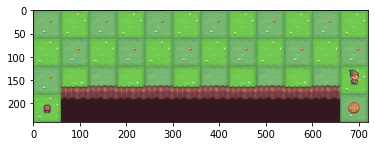

KeyboardInterrupt: ignored

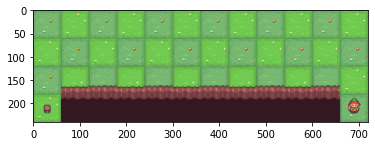

In [25]:
# run a test episode
print()
print('TEST EPISODE')
r = train_agent(SARSA_agent, env, n_episodes=1, explore_rate=0, display=True, simple_text = True) # run a test episode to get the learned behaviour with no exploring


Now we can plot the Q function which shows us the stat-action values the agent has learned and the agents learned policy overlaid on the state-value plot. 

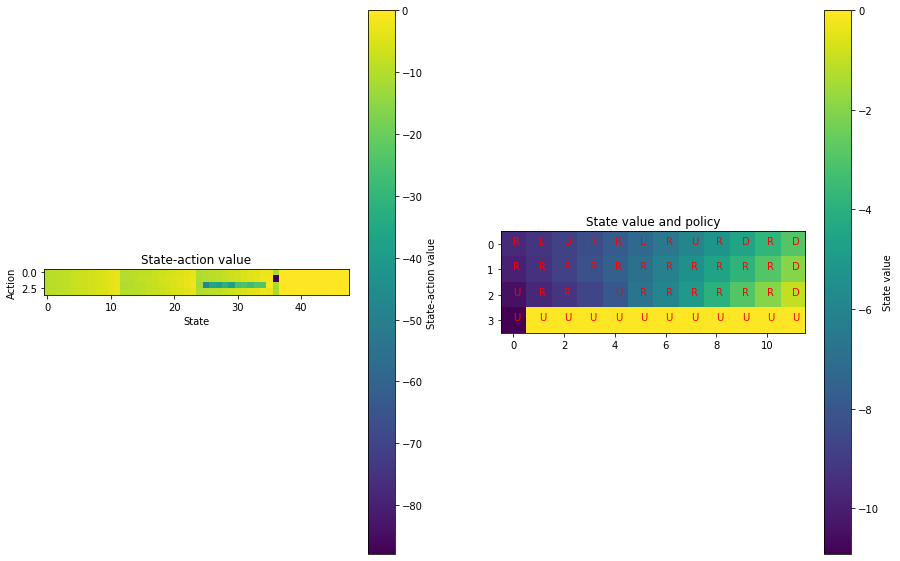

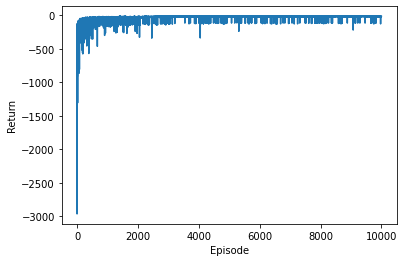

In [ ]:
# plot value function, policy and return 
plot_value(SARSA_agent.Q_func, grid_shape, p_map) # plot the value function and policy 
plot_returns(returns)

### Q-learning agent

We will now modify our agent so that we are doing Q learning. How is this update rule different from the SARSA one above?

In [ ]:
def Q_update(self,transition):
    '''
    updates the agents value function based on the experience in transition
    :param transition:
    :return:
    '''

    state, action, reward, next_state, next_action, done = transition

    self.Q_func[state, action] += self.alpha * (reward + self.gamma * np.max(self.Q_func[next_state]) * (1 - done) - self.Q_func[state, action])

TD_agent.update_Q = Q_update



In [ ]:
Q_agent = TD_agent(n_states, n_actions)
print('TRAINING')
returns = train_agent(Q_agent, env, explore_rate = 0.05) # train the agent

TRAINING
episode: 0 , explore_rate: 0.05 , return: -107
episode: 1000 , explore_rate: 0.05 , return: -39
episode: 2000 , explore_rate: 0.05 , return: -29
episode: 3000 , explore_rate: 0.05 , return: -21
episode: 4000 , explore_rate: 0.05 , return: -117
episode: 5000 , explore_rate: 0.05 , return: -231
episode: 6000 , explore_rate: 0.05 , return: -13
episode: 7000 , explore_rate: 0.05 , return: -13
episode: 8000 , explore_rate: 0.05 , return: -123
episode: 9000 , explore_rate: 0.05 , return: -15
episode: 10000 , explore_rate: 0.05 , return: -17


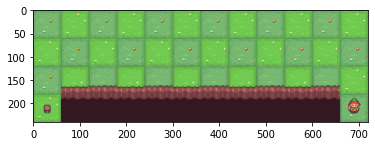

In [ ]:
# run a test episode
print()
print('TEST EPISODE')
r = train_agent(Q_agent, env, n_episodes=1, explore_rate=0, display=True, simple_text = True) # run a test episode to get the learned behaviour with no exploring


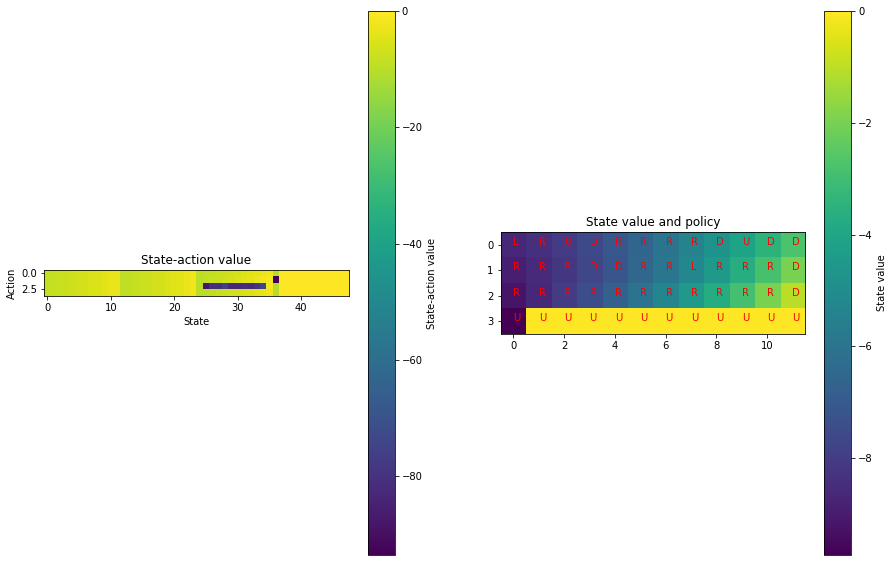

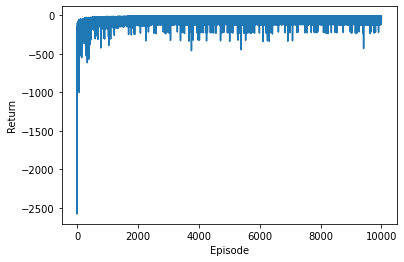

In [ ]:
# plot value function, policy and return 
plot_value(Q_agent.Q_func, grid_shape, p_map) # plot the value function and policy 
plot_returns(returns)

### See if you can answer these questions
1. What is the key difference in the update rules of the Q learning and SARSA agents? 
2. Train both agents
3. What is the final return (in the test episode) of the Q learning and SARSA agents?
4. What differences do you notice in the learned behaviours? Why are they different?
5. What does the region of the state-action plot with very low value correspond to?
6. Try increasing the explore rate for each agent, e.g. to 0.3. What is the effect on the behaviour of each agent. Remember to run the relevant cell to set the agents update rule to either Q learning or SARSA

# 2. Monte carlo agent
1. Try and train the monte carlo agent. If it gets stuck try restarting the cell a few times, training could take around 5-10 minutes.
2. Have a look at the train_agent function in the first cell. Can you see where the agents Q-functions are updated, why is the monte-carlo updated in a different place to the temporal difference agents?
3. Sometimes MC can get stuck in an episode for a long time, why is this?
4. Does the learned policy look more like the SARSA or Q-learning agent's, why?

In [ ]:
# train the agent 
M_agent = MC_agent(n_states, n_actions)
returns = train_agent(M_agent, env,n_episodes=10001,  monte_carlo=True, explore_rate=0.3)


episode: 0 , explore_rate: 0.3 , return: -22351


KeyboardInterrupt: ignored

In [ ]:
# run test episode
r = train_agent(M_agent, env, n_episodes=1, explore_rate=0, display=True, monte_carlo=True, simple_text = True)


In [ ]:
#plot value function, policy and return
plot_value(M_agent.Q_func, grid_shape, p_map)
plot_returns(returns)